In [27]:
import matplotlib.pyplot as plt
import numpy as np
from snsphd import viz
import json
%config InlineBackend.figure_formats = ['svg']
Colors, palette = viz.phd_style(jupyterStyle = True, grid=True)
from pydantic import BaseModel, validator, Field
from IPython.display import JSON

from scipy.optimize import curve_fit


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [113]:
with open("../data/data_0.25_4.0_2022-05-03 17_31_04.198889.json", 'r') as f:
    data_1 = json.load(f)


with open("../data/data_0.25_4.0_2022-05-03 19_53_28.047144.json", 'r') as f:
    data_2 = json.load(f)
# print(json.dumps(data, indent=2))

In [148]:
class FringeData(BaseModel):
    counts: np.ndarray = Field(alias="master_counts")
    current: np.ndarray = Field(alias="master_current")
    times: np.ndarray = Field(alias="master_times")
    voltage: np.ndarray = Field(alias="voltage_array")
    power: np.ndarray = None
    norm_counts: np.ndarray = None
    norm_std: np.ndarray = None
    raw_counts: np.ndarray = None
    low_bound: np.ndarray = None
    high_bound: np.ndarray = None


    # note: this is specific to pydantic <2.0 and might be deprecated
    @validator('*', pre=True)
    def to_numpy_float(cls, value) -> np.ndarray:
        if type(value[0]) is float:
            return np.array(value, dtype=float)
        else:
            return np.array(value, dtype=int)
    class Config:
        arbitrary_types_allowed = True
        allow_population_by_field_name = True

    def __init__(self, **data):
        super().__init__(**data)
        self.counts = self.counts/self.times
        self.power = self.voltage * self.current
        self.norm_counts = self.counts / np.max(self.counts)
        # self.raw_counts = self.counts
        
        self.norm_std = np.sqrt(self.counts)
        self.low_bound = (self.counts - self.norm_std)/np.max(self.counts)
        self.high_bound = (self.counts + self.norm_std)/np.max(self.counts)

        

fringe_data_1 = FringeData(**data_1)
fringe_data_2 = FringeData(**data_2)

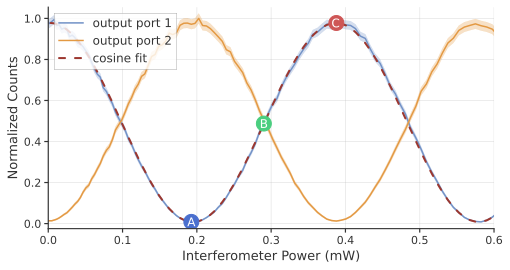

In [240]:

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
power_offset = .13


def cos_func(x, a, b, c, d):
    return a * np.cos(b * x + c) + d

st = 68
st2 = 68
ax.plot(fringe_data_1.power[st:] - power_offset, fringe_data_1.norm_counts[st:], color=Colors['blue'], lw=1.5, label="output port 1")
plt.fill_between(fringe_data_1.power[st:] - power_offset, fringe_data_1.low_bound[st:], fringe_data_1.high_bound[st:], color=Colors['blue'], alpha=0.3)

ax.plot(fringe_data_1.power[st2:] - power_offset, fringe_data_2.norm_counts[st2:], color=Colors['orange'], lw=1.5, label="output port 2")
plt.fill_between(fringe_data_1.power[st2:] - power_offset, fringe_data_2.low_bound[st2:], fringe_data_2.high_bound[st2:], color=Colors['orange'], alpha=0.3)


ax.set_xlim(0,.6)
p0 = [0.5, 16, np.pi/2, 0.5] #initial guess

popt, pcov = curve_fit(cos_func, fringe_data_1.power[st:], fringe_data_1.norm_counts[st:], sigma = np.sqrt(fringe_data_1.counts[st:])/np.max(fringe_data_1.counts[st:]), p0 = p0)


plt.plot(fringe_data_1.power - power_offset, cos_func(fringe_data_1.power, *popt), ls=':', dashes=(3, 5), label='cosine fit', linewidth=2, alpha=1, color=Colors['dark_red'])
plt.legend()
plt.legend(frameon=True, fancybox=False, loc='upper left')
plt.xlabel('Interferometer Power (mW)')
plt.ylabel('Normalized Counts')

nudge_y = -0.005
nudge_x = -0.001

Cx = fringe_data_1.power[np.argmax(cos_func(fringe_data_1.power, *popt))] - power_offset
Cy = np.max(cos_func(fringe_data_1.power, *popt))
ax.plot([Cx], [Cy], marker='o', markersize=15, color="#ce5656")
ax.text(Cx+nudge_x, Cy+nudge_y, "C", ha='center', va='center', color='white', fontsize=12)


Ax = fringe_data_1.power[np.argmin(cos_func(fringe_data_1.power, *popt))] - power_offset
Ay = np.min(cos_func(fringe_data_1.power, *popt))
ax.plot([Ax], [Ay], marker='o', markersize=15, color="#4a6fce")
ax.text(Ax, Ay+nudge_y, "A", ha='center', va='center', color='white', fontsize=12)

Bx = fringe_data_1.power[np.argmin(np.abs(cos_func(fringe_data_1.power, *popt) - popt[-2]/2))] - power_offset
By = popt[-2]/2
ax.plot([Bx], [By], marker='o', markersize=15, color="#4ace7f")
ax.text(Bx, By+nudge_y, "B", ha='center', va='center', color='white', fontsize=12)

plt.savefig("fringe.svg")
plt.savefig("fringe.pdf")
